<a href="https://colab.research.google.com/github/Srajan1122/Hyperspectral_Image_Classification/blob/srajan/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from scipy import io
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder 
from sklearn import preprocessing

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Genetic Algorithm for Optimizing the parameters

In [0]:
import random
from sklearn.metrics import f1_score
import numpy as np

class POGA:
  def __init__(self, numberOfParents, X_train, X_test, y_train, y_test, numParents, generationNumber):
    self.score_list = []
    self.population_list = []
    self.start_population = self.initilialize_population(numberOfParents)
    
    for i in range(generationNumber):
      print('Generation',i+1, 'started')
      self.score = self.train_population(self.start_population, X_train, X_test, y_train, y_test)
      self.score_list.append(self.score.copy())

      self.best_parents = self.new_parents_selection(self.start_population, self.score, numParents)
    
      self.childrens = self.crossover_uniform(self.best_parents,
                                              (len(self.start_population)-len(self.best_parents),len(self.start_population[0]))
                                              )                                  
      
      self.mutated_childrens = self.mutation(self.childrens, 5)

      self.start_population = self.best_parents + self.mutated_childrens
      self.population_list.append(self.start_population)
      print('Generation',i+1, 'finished')


  def initilialize_population(self, numberOfParents):
    hidden_layer_sizes = []
    alpha =[]
    batch_size = []
    learning_rate_init = []
    n_iter_no_change = []
    # beta_1 beta_2 epsilon

    for i in range(numberOfParents):

      hidden_layer = []
      for i in range(5):
        hidden_layer.append(random.randrange(16, 150))

      hidden_layer_sizes.append(hidden_layer)
      alpha.append(random.choice(np.logspace(-5, 5, 11)))
      batch_size.append(random.randrange(200, 1000, 10)) 
      learning_rate_init.append(random.choice(np.logspace(-1,-5, 5)))
      n_iter_no_change.append(random.randrange(1, 500, 10))

    population = zip(hidden_layer_sizes,
                     alpha,
                     batch_size,
                     learning_rate_init,
                     n_iter_no_change)
    return list(population)

  def train_population(self, population, X_train, X_test, y_train, y_test ):
    Fscore = []
    for i in list(population):
      model = MLPClassifier(
                      hidden_layer_sizes=i[0],
                      activation='relu',
                      solver='adam',
                      alpha=i[1],
                      batch_size=i[2],
                      learning_rate='constant',
                      learning_rate_init=i[3],
                      power_t=0.5,
                      max_iter=1000,
                      shuffle=True,
                      random_state=1,
                      tol=0.0001,
                      verbose=False,
                      warm_start=False,
                      momentum=0.9,
                      nesterovs_momentum=True,
                      early_stopping=False,
                      validation_fraction=0.18,#0.33 0.18
                      beta_1=0.9,
                      beta_2=0.999,
                      epsilon=1e-08,
                      n_iter_no_change=i[4],
                      max_fun=15000)
      model.fit(X_train, y_train)
      prediction = model.predict(X_test)
      Fscore.append(f1_score(y_test, prediction, average="weighted"))

    return Fscore

  def new_parents_selection(self, population, fitness, numParents):
    new_parents = []
    for i in range(numParents):
      max_fitness_index = fitness.index(max(fitness))
      new_parents.append(population[max_fitness_index])
      fitness[max_fitness_index] = -1
    return new_parents

  def crossover_uniform(self, parents, children_size):
    crossoverPointIndex = np.arange(0, np.uint8(children_size[1]), 1, dtype= np.uint8)
    crossoverPointIndex1 = np.random.randint(0, np.uint8(children_size[1]), np.uint8(children_size[1]/2))
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1)))

    children = [[0]*children_size[1]]*children_size[0]

    for i in range(children_size[0]):
      parent1_index = i%len(parents)
      parent2_index = (i+1)%len(parents)
      for j in crossoverPointIndex1:
        children[i][j] = parents[parent1_index][j]
      for j in crossoverPointIndex2:
        children[i][j] = parents[parent1_index][j]

    return children

  def mutation(self, crossover, numberOfParameters):
    minMaxValue = np.zeros((numberOfParameters, 2))

    minMaxValue[0:] = [16, 150] # hidden_layer_sizes
    minMaxValue[1:] = [0.00001, 10000] # alpha
    minMaxValue[2:] = [200, 1000] # batch_size
    minMaxValue[3:] = [0.000001, 0.1] # learning_rate_init
    minMaxValue[4:] = [1,500] # n_iter_no_change

    parameterSelect = random.randint(0, numberOfParameters-1)
    if parameterSelect == 0:
      mutationValue = random.choice(list(range(-30,40,10)))
    elif parameterSelect == 1:
      mutationValue = random.choice([0.1,10])
    elif parameterSelect == 2:
      mutationValue = random.randint(-50, 30)
    elif parameterSelect == 3:
      mutationValue = random.choice([0.1,10])
    elif parameterSelect == 4:
      mutationValue = random.randint(-50, 50)

    for i in crossover:
      if parameterSelect == 2 or parameterSelect == 4:
        i[parameterSelect] = i[parameterSelect] + mutationValue
      elif parameterSelect == 1 or parameterSelect == 3:
        i[parameterSelect] = i[parameterSelect] * mutationValue
      elif parameterSelect == 0:
        for j in range(len(i[parameterSelect])):
          if(random.choice([True,False])):
            i[parameterSelect][j] = i[parameterSelect][j] + mutationValue
            if i[parameterSelect][j]  < minMaxValue[parameterSelect, 0]:
               i[parameterSelect][j] = minMaxValue[parameterSelect, 0]
            if i[parameterSelect][j]  > minMaxValue[parameterSelect, 1]:
               i[parameterSelect][j] = minMaxValue[parameterSelect, 1]
        return crossover

      if i[parameterSelect] < minMaxValue[parameterSelect, 0]:
        i[parameterSelect] = minMaxValue[parameterSelect, 0]
      elif i[parameterSelect] > minMaxValue[parameterSelect, 1]:
        i[parameterSelect] = minMaxValue[parameterSelect, 1]

    return crossover
  
  def best_parameters(self):
    best_index = self.score_list[-1].index(max(self.score_list[-1]))
    parameters = self.population_list[-1][best_index]
    best_parameters = {}
    best_parameters['hidden_layer_sizes'] = parameters[0]
    best_parameters['alpha'] = parameters[1]
    best_parameters['batch_size'] = parameters[2]
    best_parameters['learning_rate_init'] = parameters[3]
    best_parameters['n_iter_no_change'] = parameters[4]

    return best_parameters


In [24]:
import random
alphas = np.logspace(-5, 5, 11)
learning = np.logspace(-1,-5, 5)
tol = np.logspace(-4,-5, 2)
hidden_layer = []
for i in range(5):
  hidden_layer.append(random.randrange(16, 150))

learning

array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05])

## Loading DataSet
### Dataset include image and a ground truth

In [0]:
loaded_dataset = io.loadmat('/content/drive/My Drive/Srajan/Internship/SEM4-LeadingindiaAI/Tasks/Datasets/IndianPines/Indian_pines_corrected.mat')
image = loaded_dataset['indian_pines_corrected']

In [0]:
ground_truth = io.loadmat('/content/drive/My Drive/Srajan/Internship/SEM4-LeadingindiaAI/Tasks/Datasets/IndianPines/Indian_pines_gt.mat')
ground_truth = ground_truth['indian_pines_gt']

### Class Labels

In [0]:
label_values = ["Alfalfa", "Corn-notill", "Corn-mintill",
                        "Corn", "Grass-pasture", "Grass-trees",
                        "Grass-pasture-mowed", "Hay-windrowed", "Oats",
                        "Soybean-notill", "Soybean-mintill", "Soybean-clean",
                        "Wheat", "Woods", "Buildings-Grass-Trees-Drives",
                        "Stone-Steel-Towers"]

### Resizing the data

In [0]:
image_with_gt = np.dstack((image, ground_truth))

In [0]:
final_output = image_with_gt.reshape(ground_truth.size, image.shape[2]+1)

### Visualizing data in pandas

In [0]:
data = pd.DataFrame(final_output)

In [31]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


### Droping the row if ground_truth value is zero

In [32]:
print("Percentage of column which will be droped",(data.size - data[data[200] == 0].size)/data.size,"%")

Percentage of column which will be droped 0.48746730083234247 %


In [0]:
data = data[data.iloc[:, -1] != 0]

### Spliting the data into feature and target

In [0]:
X = data.iloc[:, :-1]
y = data.iloc[:,-1]

### Correlation between the features

In [0]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(150, 200))
# sns.heatmap(X.corr(), annot=True, vmin=-1, vmax=1, center= 0)

### Feature Selection


In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

X = SelectKBest(f_classif, k=150).fit_transform(X, y)

### OneHotEncoding the target column

In [0]:
onehotencoder = OneHotEncoder() 
y = onehotencoder.fit_transform(np.array(y).reshape(-1,1)).toarray() 

### Standardizing the feature columns

In [0]:
X = preprocessing.scale(X)

### Spliting the data into training and testing set 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)#0.25 0.15

In [40]:
import time
start = time.time()
model = POGA(numberOfParents=8, numParents=4, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, generationNumber=8)
end = time.time()
print('time taken', end-start)

Generation 1 started


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Generation 1 finished
Generation 2 started


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Generation 2 finished
Generation 3 started


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Generation 3 finished
Generation 4 started


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Generation 4 finished
Generation 5 started


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Generation 5 finished
Generation 6 started


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Generation 6 finished
Generation 7 started


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Generation 7 finished
Generation 8 started


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Generation 8 finished
time taken 10821.245257854462


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [54]:
best_parameters = model.best_parameters()
best_parameters

{'alpha': 0.1,
 'batch_size': 530,
 'hidden_layer_sizes': [61, 149, 52, 69, 85],
 'learning_rate_init': 0.001,
 'n_iter_no_change': 401}

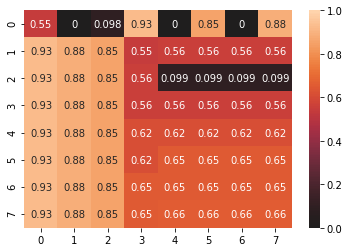

In [53]:
import seaborn as sns 
sns.heatmap(model.score_list, annot=True, vmin=0, vmax=1, center= 0)

## Preparing ANN model 
### Defining the model
[Link to learn about the parameters](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)


In [0]:
model = MLPClassifier(hidden_layer_sizes=tuple(best_parameters['hidden_layer_sizes']),
                      activation='relu',
                      solver='adam',
                      alpha=best_parameters['alpha'],
                      batch_size=best_parameters['batch_size'],
                      learning_rate='constant',
                      learning_rate_init=best_parameters['learning_rate_init'],
                      power_t=0.5,
                      max_iter=1000,
                      shuffle=True,
                      random_state=1,
                      tol=0.0001,
                      verbose=False,
                      warm_start=True,
                      momentum=0.9,
                      nesterovs_momentum=True,
                      early_stopping=False,
                      validation_fraction=0.18,#0.33 0.18
                      beta_1=0.9,
                      beta_2=0.999,
                      epsilon=1e-08,
                      n_iter_no_change=best_parameters['n_iter_no_change'],
                      max_fun=15000)

### Fitting the model

In [86]:
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.1, batch_size=530, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(61, 149, 52, 69, 85),
              learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
              max_iter=1000, momentum=0.9, n_iter_no_change=401,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.18,
              verbose=False, warm_start=True)

## Accuracy

In [87]:
model.score(X_train,y_train)

0.9998852026173803

# Prediction 

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,cohen_kappa_score
prediction = model.predict(X_test)

In [89]:
accuracy_score(y_test, prediction)

0.9161248374512354

In [90]:
precision_score(y_test, prediction,average="weighted")

0.9335779335062789

In [91]:
recall_score(y_test, prediction, average="weighted")

0.922626788036411

In [92]:
f1_score(y_test, prediction, average="weighted")

0.9274671309625515

In [93]:
cohen_kappa_score(y_test.argmax(axis=1), prediction.argmax(axis=1), labels=list(x for x in range(1,17)), weights=None, sample_weight=None)

0.9315264082354964

In [94]:
print(classification_report(y_test, prediction, target_names=label_values))

                              precision    recall  f1-score   support

                     Alfalfa       0.75      1.00      0.86         6
                 Corn-notill       0.94      0.87      0.91       220
                Corn-mintill       0.91      0.93      0.92       125
                        Corn       0.91      0.76      0.83        42
               Grass-pasture       0.96      0.93      0.94        72
                 Grass-trees       0.98      1.00      0.99       105
         Grass-pasture-mowed       1.00      0.75      0.86         4
               Hay-windrowed       0.99      0.97      0.98        71
                        Oats       1.00      1.00      1.00         2
              Soybean-notill       0.93      0.94      0.94       143
             Soybean-mintill       0.92      0.93      0.92       359
               Soybean-clean       0.96      0.94      0.95       105
                       Wheat       1.00      1.00      1.00        28
                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
